In [146]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [147]:
from google.colab import drive
drive.mount('/content/drive')
!tar -xf "/content/drive/MyDrive/Academics/Courses/Machine Learning/HW4/data.tar.gz"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.discriminant_analysis import *

from scipy.special import gamma, factorial
from scipy.stats import multivariate_normal
from scipy import signal

from PIL import Image

import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import time

plt.style.use("ggplot")


In [4]:
class AssignmentUtils:
    def __init__(self):
        self.data_path = "data"

    def load_mnist(self, prefix, reduced=False):
        folder_name = "Reduced Fashion-MNIST" if reduced else "Fashion-MNIST"
        image_pattern = "{}_Data.csv" if reduced else "{}Data.csv"
        label_pattern = "{}_Labels.csv"if reduced else "{}Labels.csv"
        prefix = prefix.capitalize() if reduced else prefix.lower()
        
        image_loc = os.path.join(self.data_path, 
                                folder_name,
                                image_pattern.format(prefix))
                                
        label_loc = os.path.join(self.data_path, 
                                folder_name,
                                label_pattern.format(prefix))
        image_df = pd.read_csv(image_loc, header=None, index_col=False)
        label_df = pd.read_csv(label_loc, header=None, index_col=False)
        images = image_df.to_numpy()
        labels = label_df.to_numpy().ravel().astype(np.int)
        print(images.shape, labels.shape)
        return images, labels
            
    def load_faces(self, prefix_type):
        def loadImages(dirName):
            data = []
            label = []
            for root, dirs, files in os.walk(dirName):
                for file in files:
                    face = Image.open(os.path.join(root, file)) # Load image from a path
                    face = face.resize((256, 256))
                    face = np.array(face).ravel().tolist()
                    data.append(face)
                    label.append(file.split('.')[1])                   # Label of an image is in its fileName
            return np.asarray(data) , label
        folder = os.path.join(self.data_path, "FACES", prefix_type)
        return loadImages(folder)


assignment_util = AssignmentUtils()

# Q8


### Class Definitions

In [ ]:
eps = 10e-10

class DensityEstimator:
    def __init__(self):
        pass
    
    def fit(self, X):
        self._data = X.copy()
        self.n = X.shape[0]
        self.log_n = np.log(X.shape[0])
        self.dim = X.shape[1]
        
    
    def _sample_pdf(self, x):
        pass
        
    def pdf(self, X):
        return np.array(
            [self._sample_pdf(X[i,:]) for i in range(X.shape[0])], dtype=np.float
        )

class ParzenDensityEstimator(DensityEstimator):
    def __init__(self, h):
        super().__init__()
        self.h = h
        self.log_h = np.log(h)
        

    def _sample_pdf(self, x):
        k = (np.abs(x.reshape(1,-1) - self._data) < self.h/2).all(axis=-1).astype(np.float).sum(axis=0)
        log_prob = np.log(k + eps) - self.log_n - (self.dim * self.log_h)
        return log_prob
        

class KNNDensityEstimator(DensityEstimator):
    def __init__(self, k):
        super().__init__()
        self.k = k 
        self.log_k = np.log(k)

    def fit(self, X):
        self.log_coef = (X.shape[1]/2) * np.log(np.pi) - np.log(gamma(X.shape[1]/2 + 1))
        super().fit(X)

    def _sample_pdf(self, x):
        log_dists = 0.5 * np.log(((x.reshape(1, -1) - self._data) ** 2).sum(axis=-1))
        sorted_log_k_dist = log_dists[np.argsort(log_dists)]
        max_log_k_dist = sorted_log_k_dist[:self.k][-1] # Indice is one lower
        log_r_n = self.dim * max_log_k_dist
        log_prob = self.log_k - self.log_n - (log_r_n + self.log_coef)
        return log_prob


def init(_X):
    global _mat
    _mat = _X
def worker_fn(estimator):
    return estimator.pdf(_mat)


class NaiveBayesClassifier:
    class PDFEstimatorFactory:
        MAPPINGS = {
                "parzen": ParzenDensityEstimator,
                "knn": KNNDensityEstimator,
        }
        @staticmethod
        def create(pdf_type, **params):
            return NaiveBayesClassifier.PDFEstimatorFactory.MAPPINGS[pdf_type](**params)

    def __init__(self, pdf_type, **pdf_estimator_params):
        self.pdf_type = pdf_type
        self.pdf_estimator_params = pdf_estimator_params

    def fit(self, X, y):
        self.classes_ = sorted(set(y))
        self.class_log_probs_ = [np.log((y == c).sum()/len(y)) for c in self.classes_]
        self.pdf_estimators = [
            NaiveBayesClassifier.PDFEstimatorFactory.create(self.pdf_type, 
                                       **self.pdf_estimator_params) for c in self.classes_
        ]
        for idx, c in enumerate(self.classes_):
            estimator = self.pdf_estimators[idx]
            indices = y == c
            estimator.fit(X[indices, :])
    
    def predict(self, X):
        log_probs = np.zeros((X.shape[0], len(self.classes_)), dtype=np.float)
        with mp.Pool(mp.cpu_count(),
                     initializer=init,
                     initargs=(X,)) as pool:
            
            for idx, idx_log_probs in enumerate(pool.imap(worker_fn, self.pdf_estimators)):
                log_probs[..., idx] = idx_log_probs + self.class_log_probs_[idx]

        labels_idx = log_probs.argmax(axis=-1)
        labels = np.array([self.classes_[l_idx] for l_idx in labels_idx])
        return labels, log_probs

### Data preprocessing

In [ ]:
X_train, y_train = assignment_util.load_mnist("train", reduced=False)
X_test, y_test = assignment_util.load_mnist("test", reduced=False)



reducer = Pipeline([
                    ("Scaler", StandardScaler()),
                    ("PCA", PCA(n_components=0.6))
                    ])

X_train = reducer.fit_transform(X_train)
X_test = reducer.transform(X_test)


print(np.unique(y_train, return_counts=True))
print(X_train.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))
(60000, 9)


In [ ]:
def confusion_matrix_display(conf_mat, ax):
    sns.heatmap(conf_mat, annot=True,cmap='Blues', ax=ax)
    ax.set_title("Confusion Matrix", pad=20)
    ax.set_ylabel("True Labels", rotation=90, labelpad=10)
    ax.set_xlabel("Predicted Labels", rotation=0, labelpad=10)

### Q8.A

Accuracy of classifier on test data: 0.7405, h=7.28
CPU times: user 390 ms, sys: 169 ms, total: 559 ms
Wall time: 27.7 s


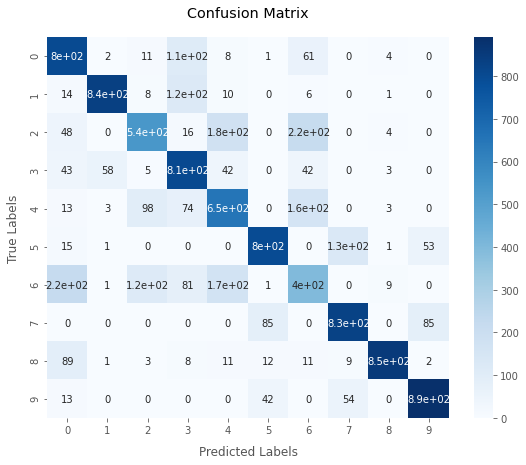

In [ ]:
%%time

h = X_train.std()
clf = NaiveBayesClassifier("parzen", h=h)
clf.fit(X_train, y_train)
preds, probs = clf.predict(X_test)

print(f"Accuracy of classifier on test data: {(preds == y_test).mean()}, h={h:.2f}")

conf_mat = confusion_matrix(y_test, preds, normalize=None)
fig, ax = plt.subplots(figsize=(9,7))
confusion_matrix_display(conf_mat, ax)

### Q8.B

h = 0.728 --> acc = 0.113
h = 7.282 --> acc = 0.741
h = 72.822 --> acc = 0.219
CPU times: user 798 ms, sys: 124 ms, total: 921 ms
Wall time: 804 ms


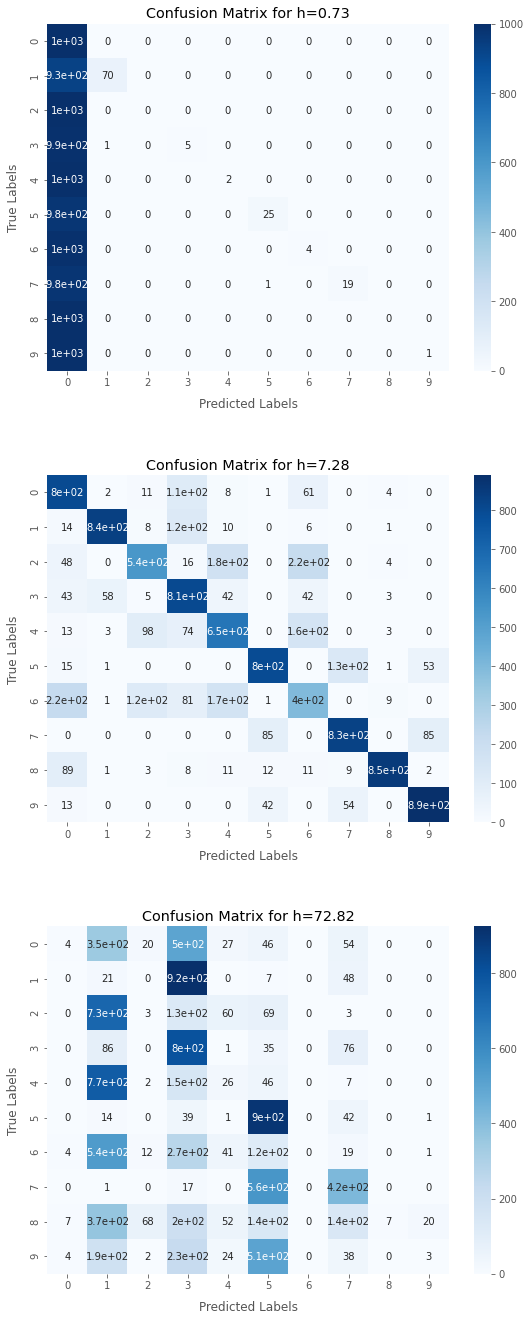

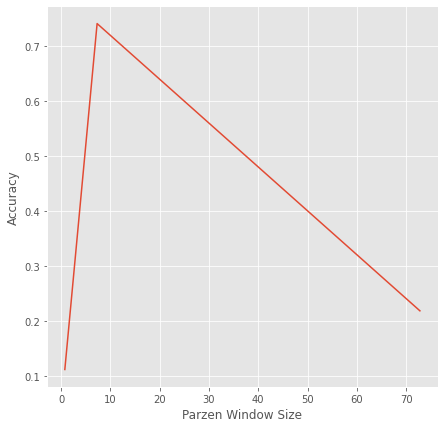

In [ ]:
%%time
H = np.array([0.1, 1, 10]) * X_train.std()
fig, axes = plt.subplots(3, 1, figsize=(9, 23), gridspec_kw={"hspace":0.3})
accs = []
confmats = []
for idx, h in enumerate(H):
  clf = NaiveBayesClassifier("parzen", h=h)
  clf.fit(X_train, y_train)
  preds, probs = clf.predict(X_test)
  accs.append(
      (preds == y_test).mean()
  )
  conf_mat = confusion_matrix(y_test, preds)
  confmats.append(conf_mat)

for ax, conf_mat, h in zip(axes, confmats, H):
    confusion_matrix_display(conf_mat, ax)
    ax.set_title(f"Confusion Matrix for h={h:.2f}")

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(H, accs)
ax.set_xlabel("Parzen Window Size")
ax.set_ylabel("Accuracy")
print(
    "\n".join([f"h = {h:.3f} --> acc = {acc:.3f}" for h, acc in zip(H, accs)])
)

### Q8.C

2
20
200
k = 2.000 --> acc = 0.786
k = 20.000 --> acc = 0.789
k = 200.000 --> acc = 0.743
CPU times: user 1.97 s, sys: 442 ms, total: 2.41 s
Wall time: 3min 33s


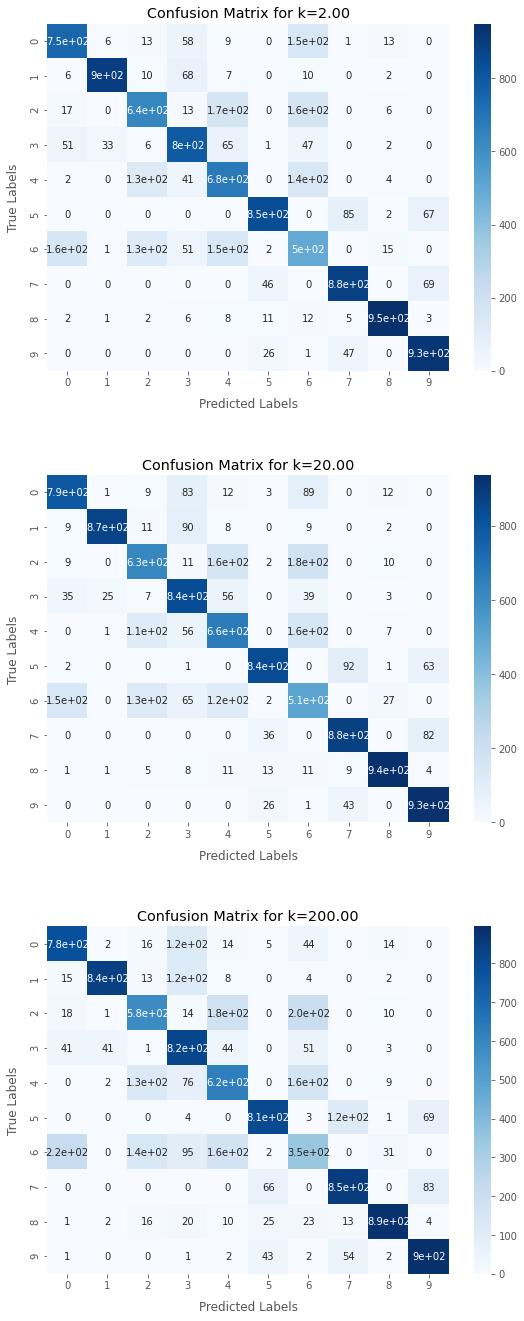

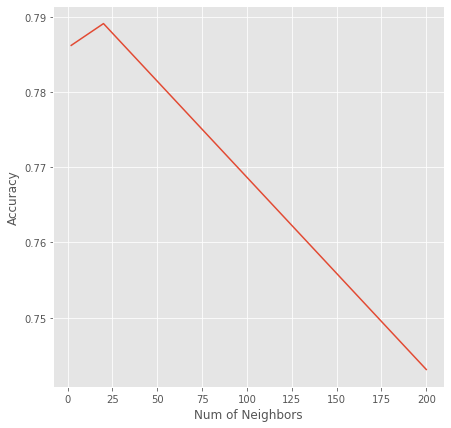

In [ ]:
%%time
K = np.array([2 , 20, 200])
fig, axes = plt.subplots(3, 1, figsize=(9, 23), gridspec_kw={"hspace":0.3})
accs = []
confmats = []
for k in K:
  print(k)
  clf = NaiveBayesClassifier("knn", k=k)
  clf.fit(X_train, y_train)
  preds, probs = clf.predict(X_test)
  preds = preds
  accs.append(
      (preds == y_test).mean()
  )
  conf_mat = confusion_matrix(y_test, preds)
  confmats.append(conf_mat)

for ax, conf_mat, k in zip(axes, confmats, K):
    confusion_matrix_display(conf_mat, ax)
    ax.set_title(f"Confusion Matrix for k={k:.2f}")

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(K, accs)
ax.set_xlabel("Num of Neighbors")
ax.set_ylabel("Accuracy")

print(
    "\n".join([f"k = {k:.3f} --> acc = {acc:.3f}" for k, acc in zip(K, accs)])
)

### Q8.D

In [ ]:
%%time
N = [2**n for n in range(np.log2(len(X_train)).astype(int))]

d = X_train.shape[1]
# h0 = X_train.std() * ((X_train.shape[0]) ** (1/(2*d)))
h0 = X_train.std()
print(h0)
accs = {"parzen": [], "knn": []}
for n in N:
    indices = np.random.choice(np.arange(X_train.shape[0]), size=(n,))
    
    h = (n ** - (1/ (2* d))) * h0
    print(n, h, np.sqrt(n))
    clf = NaiveBayesClassifier("parzen", h=h)
    clf.fit(
        X_train[indices,:], y_train[indices]
    )
    preds, probs = clf.predict(
        X_test   
    )
    accs["parzen"].append(
        (preds == y_test).mean() * 100
    )
    clf = NaiveBayesClassifier("knn", k=int(np.sqrt(n)))
    clf.fit(
        X_train[indices, :], y_train[indices]
    )
    preds, probs = clf.predict(
        X_test   
    )
    accs["knn"].append(
        (preds == y_test).mean() * 100
    )


7.2821696781683745
1 7.2821696781683745 1.0
2 7.007077248641376 1.4142135623730951
4 6.7423767556013745 2.0
8 6.487675631560652 2.8284271247461903
16 6.242596138724936 4.0
32 6.006774808784485 5.656854249492381
64 5.779861903867702 8.0
128 5.5615208978578785 11.313708498984761
256 5.3514279773037785 16.0
512 5.149271561183916 22.627416997969522
1024 4.954751838812292 32.0
2048 4.767580325200285 45.254833995939045
4096 4.587479433215255 64.0
8192 4.41418206190136 90.50966799187809
16384 4.247431200352036 128.0
CPU times: user 951 ms, sys: 1.47 s, total: 2.42 s
Wall time: 1min 27s


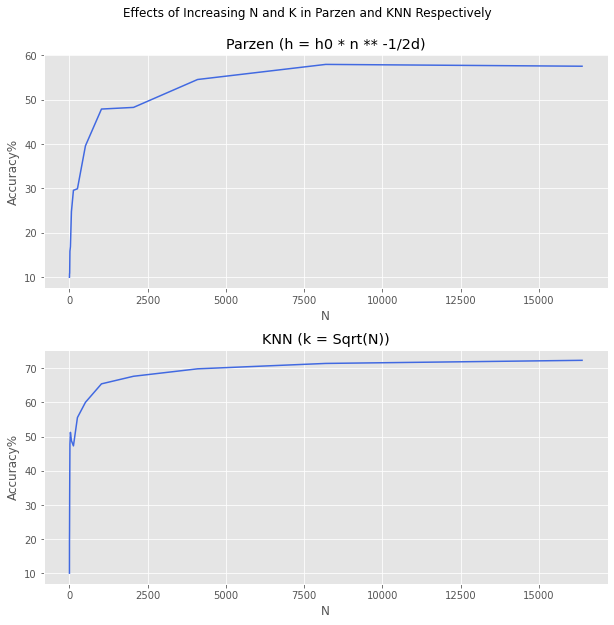

In [ ]:
accs_df = pd.DataFrame(accs)

fig, axes = plt.subplots(2, 1, figsize=(9,9))
ax = axes[0]
ax.plot(
    N, accs_df["parzen"], label="Parzen", color="royalblue"
)
ax.set_title("Parzen (h = h0 * n ** -1/2d)")
ax.set_xlabel("N")
ax.set_ylabel("Accuracy%")

ax = axes[1]
ax.plot(
    N, accs_df["knn"], label="KNN", color="royalblue"
)

ax.set_title("KNN (k = Sqrt(N))")
ax.set_xlabel("N")
ax.set_ylabel("Accuracy%")

fig.suptitle("Effects of Increasing N and K in Parzen and KNN Respectively")    
plt.tight_layout(
    rect=(0.02,0.02, 0.98, 0.95)
)

# Q9

### Implementations

In [ ]:
class BaseSelection:
    def __init__(self, k, tol=10e-2):
        self.k = k
        self.clf = GaussianNB()
        self.selected_indices = None
        self.tol = tol

    def fit(self, X_train, y_train, X_test, y_test):
        # creating one_hot vector
        one_hot = np.zeros((len(y_test), len(set(y_test))))
        one_hot[np.arange(len(y_test)), y_test] = 1


        self.dim = X_train.shape[1]
        self.data = []
        self.selected_indices = []
        
        iteration = 0
        while self.loop_condition():
            start_time = time.time()
            iteration+=1
            important_indice = 0
            best_mse = np.inf
            best_acc = 0
            for i in self.generate_search_indices():
                # adding the new indice
                indices = self.generate_iteration_indices(i)
                # fitting the classifier
                curr_mse, curr_acc = self.compute_mse(X_train, y_train, X_test, y_test, one_hot, indices)
                # update if needed
                if curr_mse < best_mse:
                    important_indice = i
                    best_mse = curr_mse
                    best_acc = curr_acc

            self.update_indices(important_indice)
            end_time = time.time() - start_time
            self.data.append(
                {
                    "mse": best_mse, "accuracy": best_acc, "time": end_time,
                }
            )
            print(f"Iteration #{iteration:3d}, mse: {best_mse:.3f}, acc: {best_acc:.3f}, took {end_time:.3f}s")
            
        self.selected_indices = sorted(self.selected_indices)
        self.data = pd.DataFrame(self.data)

    def loop_condition(self):
        return len(self.data) < self.k
    
    def generate_search_indices(self):
        gen = set(range(self.dim))
        gen = gen.difference(set(self.selected_indices))
        return list(gen)

    def generate_iteration_indices(self, i):
        pass

    def update_indices(self, important_indice):
        pass

    def generate_best_mse_indices(self):
        pass

    def compute_mse(self, X_train, y_train, X_test, y_test, one_hot, indices):
        self.clf.fit(X_train[..., indices], y_train)
        # getting probabilities
        probs = self.clf.predict_proba(X_test[..., indices])
        # computing mean square error for probabilites
        mse = ((one_hot - probs)**2).sum(axis=-1).mean()
        acc = (y_test == np.argmax(probs, axis=-1)).mean()
        return mse, acc 

    
class ForwardSelection(BaseSelection):
    def generate_iteration_indices(self, i):
        union = set(self.selected_indices)
        union.add(i)
        return list(union)


    def update_indices(self, important_indice):
        self.selected_indices.append(important_indice)
    
    def generate_best_mse_indices(self):
        return self.selected_indices
    
                

class BackwardElimination(BaseSelection):
    def generate_iteration_indices(self, i):
        diff = set(range(self.dim))
        diff = diff.difference(set(self.selected_indices))
        diff.remove(i)
        return list(diff)

    def update_indices(self, important_indice):
        self.selected_indices.append(important_indice)
    
    def generate_best_mse_indices(self):
        diff = set(range(self.dim))
        diff = diff.difference(set(self.selected_indices))
        return list(diff)


### Preprocessing

In [ ]:
X_train, y_train = assignment_util.load_mnist("train", reduced=True)
X_test, y_test = assignment_util.load_mnist("train", reduced=True)

encoder = OneHotEncoder()
y_test_onehot = encoder.fit(y_train.reshape(-1,1)).transform(y_test.reshape(-1,1))

reducer = Pipeline([
                    ("Scaler", StandardScaler()),
                    # ("PCA", PCA(n_components=0.9))
                    ])

X_train = reducer.fit_transform(X_train)
X_test = reducer.transform(X_test)

print(X_train.shape)

(10000, 182) (10000,)
(10000, 182) (10000,)
(10000, 182)


### Q9.A, B

In [ ]:
k = X_train.shape[1] - 1

start_time = time.time()
print("#### FORWARD")
forward = ForwardSelection(k)
forward.fit(X_train, 
             y_train, 
             X_test, 
             y_test)

print("#### BACKWARD")
backward = BackwardElimination(k)
backward.fit(X_train, 
             y_train,
             X_test, 
             y_test)



#### FORWARD
Iteration #  1, mse: 0.727, acc: 0.369, took 1.688s
Iteration #  2, mse: 0.600, acc: 0.510, took 1.982s
Iteration #  3, mse: 0.516, acc: 0.597, took 2.026s
Iteration #  4, mse: 0.469, acc: 0.658, took 2.324s
Iteration #  5, mse: 0.433, acc: 0.691, took 2.376s
Iteration #  6, mse: 0.419, acc: 0.703, took 2.467s
Iteration #  7, mse: 0.406, acc: 0.714, took 2.577s
Iteration #  8, mse: 0.395, acc: 0.722, took 2.642s
Iteration #  9, mse: 0.384, acc: 0.729, took 2.747s
Iteration # 10, mse: 0.375, acc: 0.735, took 2.817s
Iteration # 11, mse: 0.368, acc: 0.743, took 3.118s
Iteration # 12, mse: 0.363, acc: 0.749, took 3.213s
Iteration # 13, mse: 0.358, acc: 0.753, took 3.502s
Iteration # 14, mse: 0.354, acc: 0.759, took 3.559s
Iteration # 15, mse: 0.350, acc: 0.762, took 3.639s
Iteration # 16, mse: 0.346, acc: 0.762, took 3.650s
Iteration # 17, mse: 0.343, acc: 0.766, took 3.727s
Iteration # 18, mse: 0.340, acc: 0.768, took 3.611s
Iteration # 19, mse: 0.337, acc: 0.772, took 3.722s

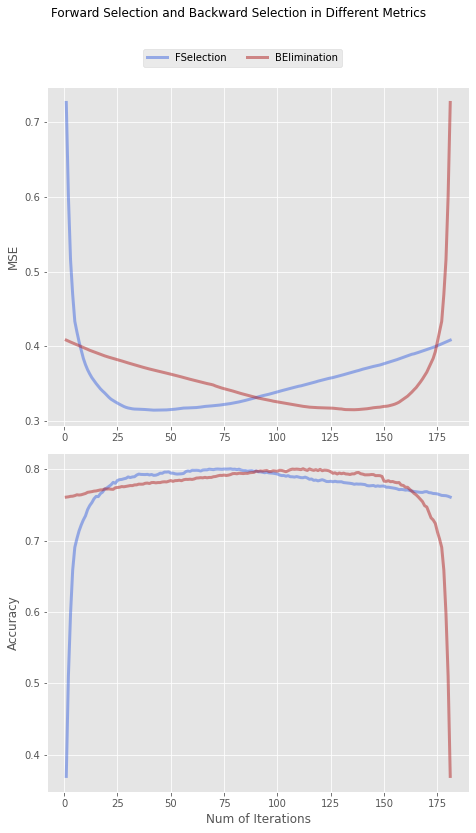

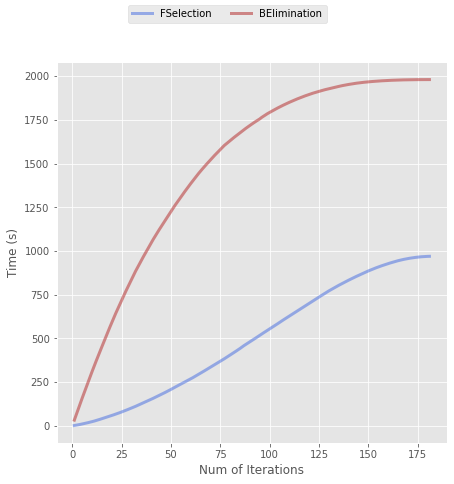

In [ ]:
fig, axes = plt.subplots(2 , 1, figsize=(7, 12),)
fig.suptitle("Forward Selection and Backward Selection in Different Metrics")

ax = axes[0]
features = np.arange(len(forward.data)) + 1
ax.plot(
    features,forward.data["mse"], color="royalblue", label="FSelection", linewidth=3, alpha=0.5
)
ax.plot(
    features,backward.data["mse"], color="firebrick", label="BElimination", linewidth=3, alpha=0.5
)

ax.set_ylabel("MSE")


ax = axes[1]
ax.plot(
    features,forward.data["accuracy"], color="royalblue", label="FSelection", linewidth=3, alpha=0.5
)
ax.plot(
    features,backward.data["accuracy"], color="firebrick", label="BElimination", linewidth=3, alpha=0.5
)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Num of Iterations")
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels, ncol=2, loc=(0.3, 0.92)
)
fig.tight_layout(rect=(0.02,0.02,0.98, 0.9))



fig, ax = plt.subplots(figsize=(7,7))
ax.plot(
    features,np.cumsum(forward.data["time"]), color="royalblue", label="FSelection", linewidth=3, alpha=0.5
)
ax.plot(
    features,np.cumsum(backward.data["time"]), color="firebrick", label="BElimination", linewidth=3, alpha=0.5
)
ax.set_ylabel("Time (s)")
ax.set_xlabel("Num of Iterations")


handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels, ncol=2, loc="upper center"
)


# Q11

In [55]:
eps = 10e-5
class CustomGaussianNB:
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.classes_ = sorted(set(y))
        self.class_probs_ = [0 for c in self.classes_]
        self.mu = [None for c in self.classes_]
        self.cov = [None for c in self.classes_]
        for idx, c in enumerate(self.classes_):
            indices = y == c
            self.mu[idx] = X[indices, ...].mean(axis=0)
            self.cov[idx] = np.cov(X[indices, ...], rowvar=False) + eps * np.eye(X.shape[1])  # numerical stability
            self.class_probs_[idx] = indices.sum() / len(y)
    
    def predict(self, X):
        log_probs = np.zeros((X.shape[0], len(self.classes_)))
        for idx, c in enumerate(self.classes_):
            class_conditional_log_prob = multivariate_normal.logpdf(X, mean=self.mu[idx], cov=self.cov[idx])
            log_probs[..., idx] =  class_conditional_log_prob + np.log(self.class_probs_[idx])
        return np.argmax(log_probs, axis=-1)



In [ ]:
# PCA using covariance matrix
class PCA:
    def __init__(self, n):
        self.n = n
        self.scaler = StandardScaler()
        
    def fit(self, X):
        X_transform = self.scaler.fit_transform(X)
        cov = np.cov(X_transform, bias=True, rowvar=False)
        eigs, vecs = np.linalg.eig(cov)
        self.eigs = eigs
        self.vecs = vecs
        self.var_ratio = eigs / np.sum(eigs)
        return self
    
    def transform(self, X):
        X_transform = self.scaler.transform(X)
        return X_transform @ self.vecs[:, :self.n]
        

In [ ]:
X_train, y_train = assignment_util.load_mnist("train", reduced=False)
X_test, y_test = assignment_util.load_mnist("test", reduced=False)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(60000, 784) (60000,)
(10000, 784) (10000,)


# Q11.A

Text(0.5, 0, 'Log N Features')

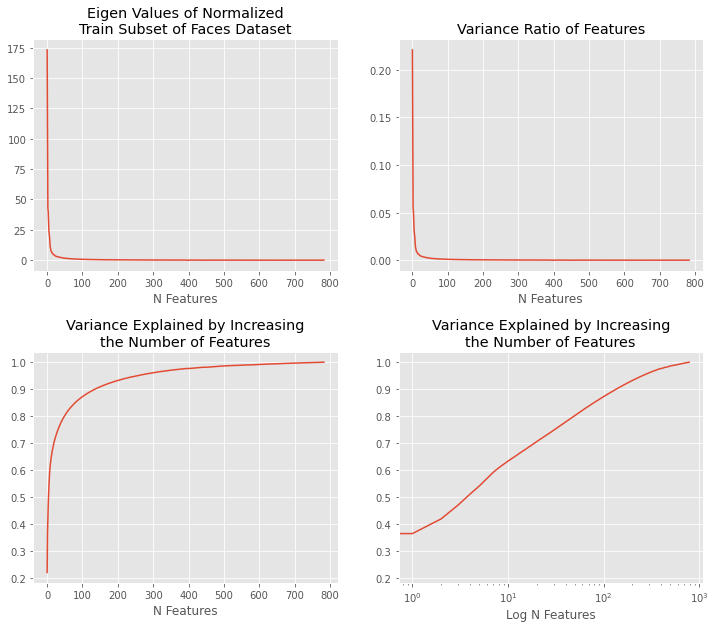

In [ ]:
pca = PCA(n=20).fit(X_train)
eigs = pca.eigs
fig, axes = plt.subplots(2, 2,figsize=(12,10), gridspec_kw={"hspace":0.35})
axes = list(axes.flat)
ax = axes[0]
ax.plot(eigs)
ax.set_title("Eigen Values of Normalized\nTrain Subset of Faces Dataset")
ax.set_xlabel("N Features")

ax = axes[1]
ax.plot(pca.var_ratio)
ax.set_title("Variance Ratio of Features")
ax.set_xlabel("N Features")

ax = axes[2]
cumsum = np.cumsum(pca.var_ratio)
ax.plot(cumsum)
ax.set_title("Variance Explained by Increasing\nthe Number of Features")
ax.set_xlabel("N Features")
ax = axes[3]

ax.plot(cumsum)
ax.set_xscale("log")
ax.set_title("Variance Explained by Increasing\nthe Number of Features")
ax.set_xlabel("Log N Features")

### Q11.B

In [ ]:
# Projecting all into a new space
pca.n = X_train.shape[1]
X_train_pca, X_test_pca = [pca.transform(x) for x in (X_train, X_test)]

4 0.6757
5 0.6974
6 0.7189
7 0.7204
8 0.7187
9 0.7128
10 0.7151
11 0.7181
13 0.7195
14 0.7213
16 0.7219
18 0.7203
20 0.7205
22 0.7142
24 0.7152
27 0.7138
30 0.7125
34 0.7132
38 0.7118
42 0.7089
47 0.7076
53 0.7074
59 0.7076
65 0.7061
73 0.7013
81 0.6969
90 0.6944
101 0.6935
112 0.6915
125 0.6904
139 0.6882
155 0.6875
173 0.686
193 0.6841
215 0.6832
239 0.6828
266 0.6805
297 0.6794
331 0.6779
368 0.6772
410 0.6773
457 0.678
509 0.6763
567 0.6779
632 0.6788
703 0.6795
783 0.6762


Text(0, 0.5, 'Accuracy')

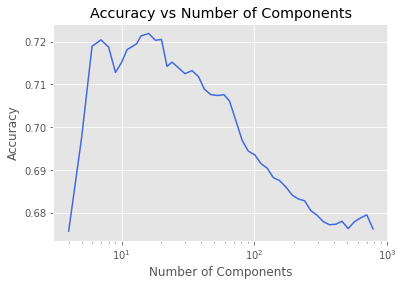

In [ ]:
n_component_list = sorted(set(np.logspace(2, np.log2(X_train.shape[1]), num=50, base=2).astype(np.int)))
accs = []
clf = CustomGaussianNB()
for n in n_component_list:
    clf.fit(X_train_pca[..., :n], y_train)
    preds = clf.predict(X_test_pca[..., :n])
    accs.append(
        (preds == y_test).mean()
    )
    print(n, accs[-1])

plt.plot(n_component_list, accs, c="royalblue", )
plt.title("Accuracy vs Number of Components")
plt.xlabel("Number of Components")
plt.xscale("log")
plt.ylabel("Accuracy")

accuracy: 0.7175


Text(0.5, 96.0, 'Predicted Labels')

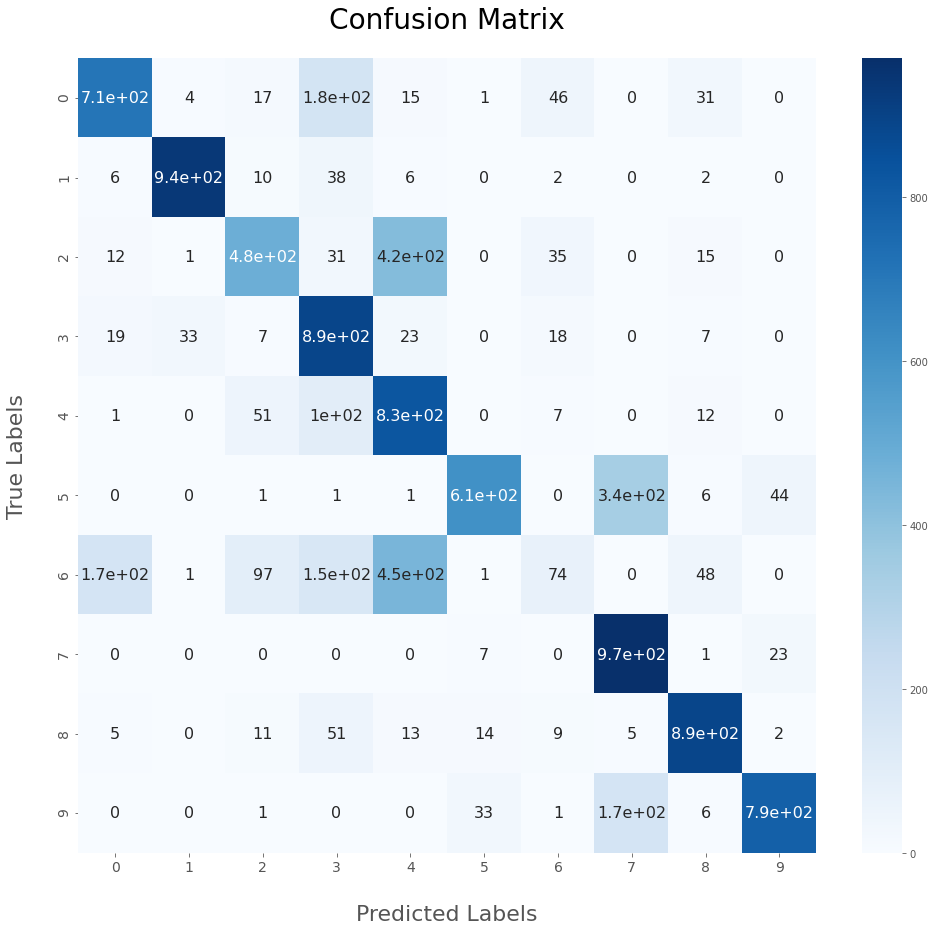

In [ ]:
n = 15
clf.fit(X_train_pca[..., :n], y_train)
preds = clf.predict(X_test_pca[..., :n])
print(f"accuracy: {(preds == y_test).mean()}")
cm = confusion_matrix(y_test, preds, normalize=None)
fig, ax = plt.subplots(figsize=(15,13))
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, cmap='Blues', ax=ax)
fig.tight_layout(rect=(0.01, 0.01,0.9, 0.9))
ax.set_title("Confusion Matrix", pad=30, fontsize=28)
ax.set_xticklabels(ax.get_xticklabels(), fontdict={"fontsize":14})
ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize":14})
ax.set_ylabel("True Labels", rotation=90, labelpad=30, fontsize=22)
ax.set_xlabel("Predicted Labels", rotation=0, labelpad=30, fontsize=22)

# Q12

In [5]:
class ScatterMatrix:
    def __init__(self, X, y):
        self.mu = X.mean(axis=0, keepdims=True)
        self.classes_, self.n_classes = np.unique(y, return_counts=True)
        self.class_means = [None for c in self.classes_]

        # SW calculation
        self._SW = np.zeros((X.shape[1], X.shape[1]), dtype=np.float)
        for idx, c in enumerate(self.classes_):
            indices = y == c
            self.class_means[idx] = X[indices, ...].mean(axis=0, keepdims=True)
            self._SW += np.cov(X[indices, ...], rowvar=False) * (indices.sum() - 1)

        self.class_means = np.array(self.class_means).squeeze()
        
        # SB calculation
        SB = np.zeros((X.shape[1], X.shape[1]), dtype=np.float)
        for idx, c in enumerate(self.class_means):
            
            SB += ((c - self.mu).T @ (c - self.mu)) * self.n_classes[idx]
        self._SB = SB

        self._ST = np.cov(X, rowvar=False, bias=False) * (len(X) - 1)
        


    
    @property
    def SB(self):
        return self._SB
            
    @property
    def SW(self):
        return self._SW

    @property
    def ST(self):
        return self._ST

In [6]:
X_train, y_train = assignment_util.load_mnist("train", reduced=True)
X_test, y_test = assignment_util.load_mnist("test", reduced=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

SM = ScatterMatrix(X_train, y_train)

(10000, 182) (10000,)
(3500, 182) (3500,)


### Q12.A

(10000, 182)


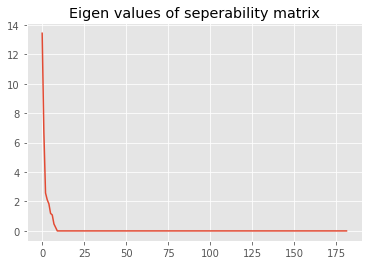

In [59]:
mat_seperability = np.linalg.pinv(SM.SW) @ SM.SB
eigs, vecs = np.linalg.eigh(mat_seperability)
args = np.argsort(eigs)[::-1]
eigs = eigs[args]
vecs = vecs[:, args]
plt.plot(eigs)
plt.title("Eigen values of seperability matrix")
X_train_lda_projection = X_train @ vecs
X_test_lda_projection = X_test @ vecs
print(X_train_lda_projection.shape)

Text(0, 0.5, 'Seperatability')

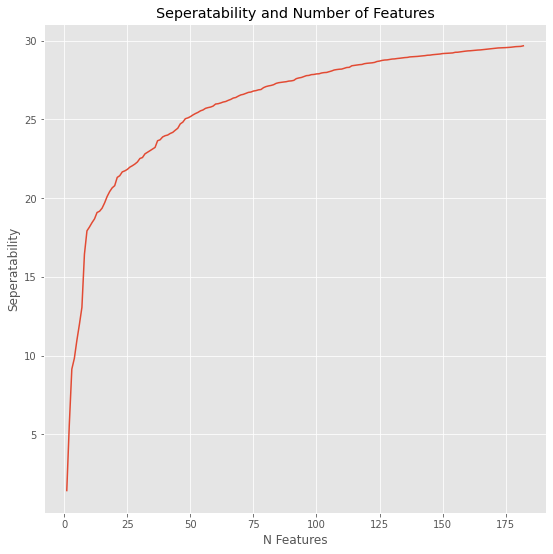

In [60]:
seperatability = []
# N = np.arange(1, vecs.shape[1]+1)
# N = sorted(set(N))
# args = np.arange(X_train.shape[1])
# np.random.RandomState(42).shuffle(args)
for n in N:
    SM = ScatterMatrix(X_train[...,:n], y_train)
    seperatability.append(np.trace(np.linalg.pinv(SM.SW) @ SM.SB))

fig, ax = plt.subplots(1, 1, figsize=(9,9))

ax.plot(N, seperatability)
ax.set_title("Seperatability and Number of Features")
ax.set_xlabel("N Features")
ax.set_ylabel("Seperatability")

### Q12.C



## Accuracy of Dim Reduced: 0.812




Text(0.5, 96.0, 'Predicted Labels')

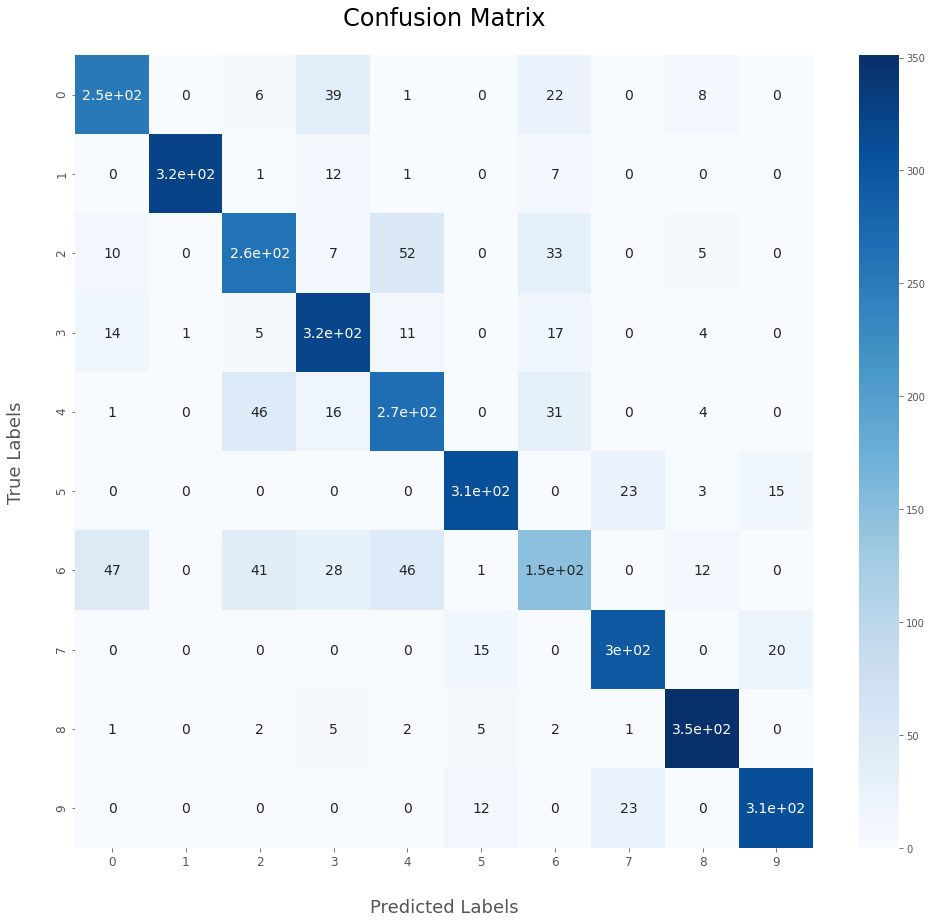

In [61]:
clf = CustomGaussianNB()
n = len(set(y_train)) - 1
clf.fit(X_train_lda_projection[:, :n], y_train)
preds = clf.predict(X_test_lda_projection[:, :n])
print(f"\n\n## Accuracy of Dim Reduced: {(preds == y_test).mean()}\n\n")
cm = confusion_matrix(y_test, preds, normalize=None)
fig, ax = plt.subplots(figsize=(15,13))
sns.heatmap(cm, annot=True,annot_kws={"size": 14}, cmap='Blues', ax=ax)
fig.tight_layout(rect=(0.01, 0.01,0.9, 0.9))
ax.set_title("Confusion Matrix", pad=30, fontsize=24)
ax.set_xticklabels(ax.get_xticklabels(), fontdict={"fontsize":12})
ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize":12})
ax.set_ylabel("True Labels", rotation=90, labelpad=30, fontsize=18)
ax.set_xlabel("Predicted Labels", rotation=0, labelpad=30, fontsize=18)

### Q12.D



## Accuracy of Normal: 0.7868571428571428




Text(0.5, 96.0, 'Predicted Labels')

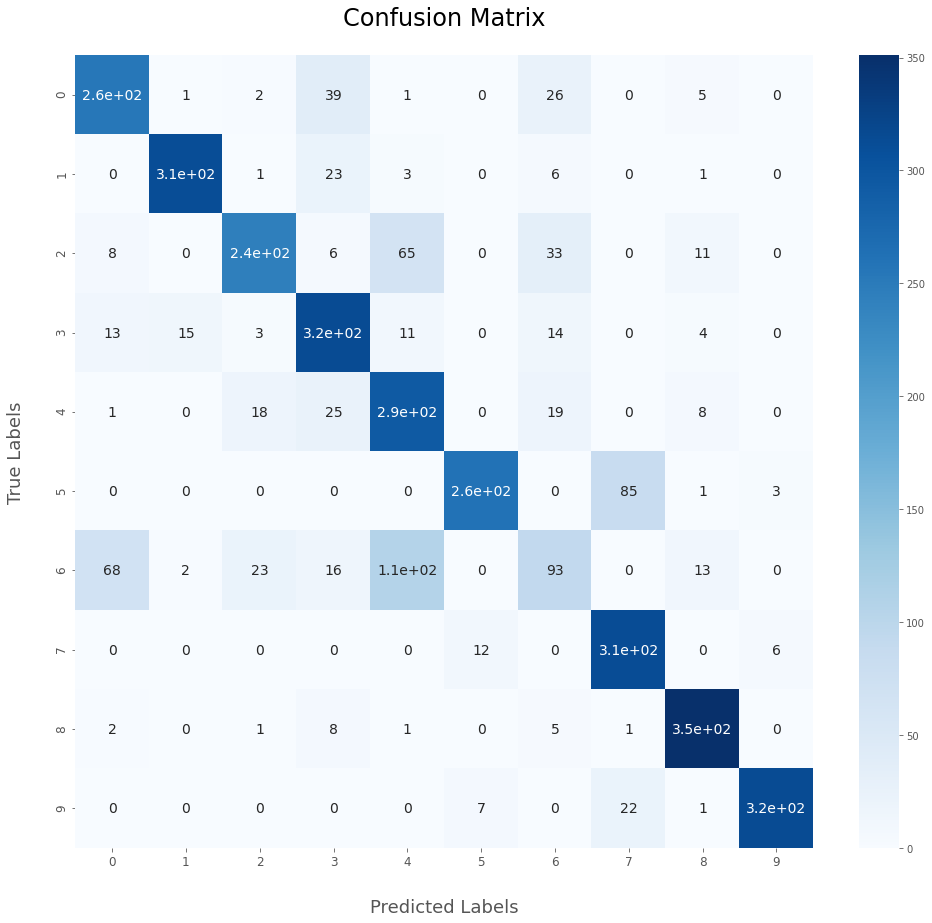

In [62]:
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(f"\n\n## Accuracy of Normal: {(preds == y_test).mean()}\n\n")
cm = confusion_matrix(y_test, preds, normalize=None)
fig, ax = plt.subplots(figsize=(15,13))
sns.heatmap(cm, annot=True,annot_kws={"size": 14}, cmap='Blues', ax=ax)
fig.tight_layout(rect=(0.01, 0.01,0.9, 0.9))
ax.set_title("Confusion Matrix", pad=30, fontsize=24)
ax.set_xticklabels(ax.get_xticklabels(), fontdict={"fontsize":12})
ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize":12})
ax.set_ylabel("True Labels", rotation=90, labelpad=30, fontsize=18)
ax.set_xlabel("Predicted Labels", rotation=0, labelpad=30, fontsize=18)

# Q13

[[-2 -7 -3]
 [ 5  6  0]
 [-8 -8 -8]]


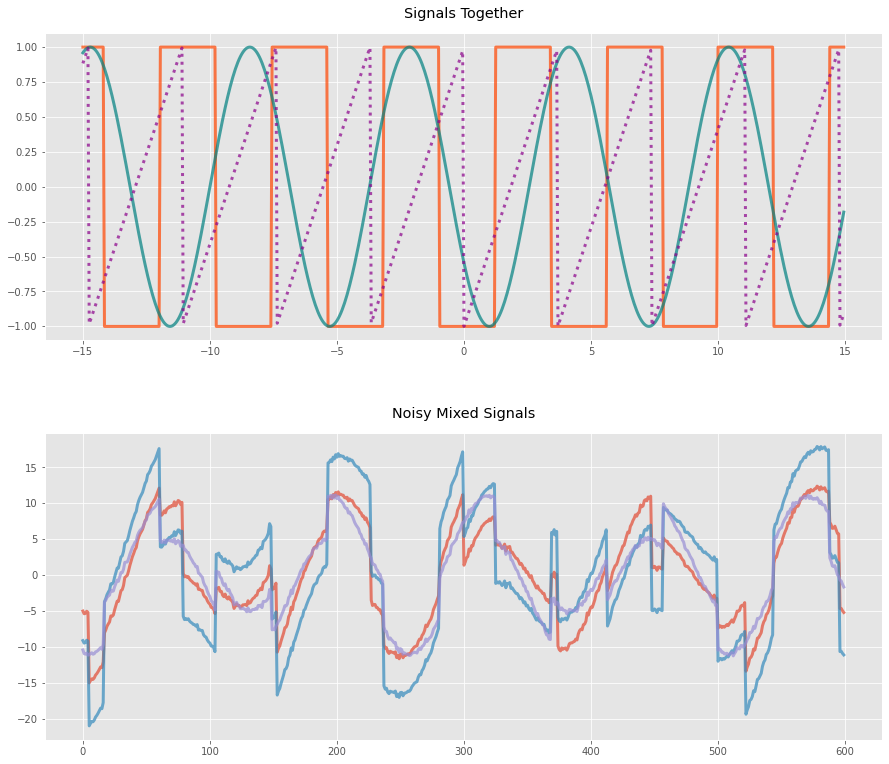

In [233]:
time = np.arange(-15, 15, 0.05)
pulse = signal.square((time-10)/0.7, 0.5)
sawtooth = signal.sawtooth(time * 1.7, 1)
sine = np.sin(time + 10)

original_signals = np.array([pulse, sawtooth, sine]).T 
noise = 0.2 * np.random.normal(loc=0, scale=1, size=(time.shape[0], 1))
# noise = noise * np.random.RandomState(100).randint(-2, 2, size=(1, 3))
A = np.random.RandomState(100).randint(-10, 10, size=(3,3))
X = original_signals @ A + noise #noisy @ A

fig, axes = plt.subplots(2, 1, figsize=(15,13), gridspec_kw={"hspace":0.3})
ax = axes[0]
ax.plot(time, pulse, color="orangered", alpha=0.7, linewidth=3)
ax.plot(time, sine, color="teal", linestyle="-", alpha=0.7, linewidth=3)
ax.plot(time, sawtooth,  color="darkmagenta", linestyle="dotted", alpha=0.7, linewidth=3)
ax.set_title("Signals Together", pad=15)


# ax = axes[1]
# ax.plot(time, noisy[:, 0], color="orangered", alpha=0.7, linewidth=3)
# ax.plot(time, noisy[:, 1], color="teal", linestyle="-", alpha=0.7, linewidth=3)
# ax.plot(time, noisy[:, 2],  color="darkmagenta", linestyle="dotted", alpha=0.7, linewidth=3)
# ax.set_title("Noisy Signals", pad=15)

ax = axes[1]
# ax.plot(time, X[:, 0], color="orangered", alpha=0.7, linewidth=3)
# ax.plot(time, X[:, 1], color="teal", linestyle="-", alpha=0.7, linewidth=3)
# ax.plot(time, X[:, 2],  color="darkmagenta", linestyle="dotted", alpha=0.7, linewidth=3)
ax.plot(X, alpha=0.7, linewidth=3)
ax.set_title("Noisy Mixed Signals", pad=15)
print(A)

In [66]:
# Subtracting mean
X_zeroed = X - X.mean(axis=0, keepdims=True)
# Whitening 
cov = np.cov(X_zeroed, rowvar=False)
eigs, vecs = np.linalg.eigh(cov)
eigs = 1 / np.sqrt(eigs)
eigs = np.diag(eigs)
whiten_matrix = vecs @ eigs
print(whiten_matrix)

[[-0.31516542  0.16255756 -0.03828173]
 [ 0.00715181 -0.22867503 -0.0570398 ]
 [ 0.30059462  0.17587794 -0.03878026]]


In [225]:
class CustomICA:
    def __init__(self):
        pass
    
    def fit(self, X, iter=1000, tol=1e-5):
        def dist(x1, x2):
            return np.linalg.norm(x1-x2)
        def _center(mat):
            mean = mat.mean(axis=0, keepdims=True)
            return mat - mean, mean
        def _whiten(mat):
            cov = np.cov(mat, rowvar=False)
            U, S, V = np.linalg.svd(cov)
            D = 1 / np.sqrt(S)
            D = np.diag(D)
            Wh = U @ D @ U.T
            return (Wh @ mat.T).T
        def _compute_w(wp, mat):
            g = lambda u: np.tanh(u)
            dg = lambda u: 1 - (g(u) ** 2)
            # X: C, N
            # w: C, 1
            N = mat.shape[1]
            w = (1/N) * ((mat @ g(wp.T @ mat).T) - (dg(wp.T @ mat) @ np.ones((N, 1)).squeeze() * wp))
            return w
        X_c, meanX = _center(X)
        X_tr = _whiten(X_c).T # to C, N
        c = X_tr.shape[0]
        print(c)
        W = np.random.rand(c, c)
        for i in range(len(W)):
            w = W[:, [i]]
            for j in range(iter):
                wp = _compute_w(w, X_tr)
                for k in range(i):
                    wk = W[:, [k]]
                    wp -= (wp.squeeze() * wk.squeeze()).sum() * wk
                wp = wp / np.sqrt((wp ** 2).sum())
                d = dist(w, wp)
                if d < tol:
                    break
                w = wp
            print(i, d)
            W[:, i] = w.squeeze()
                
        S = X_tr.T @ W - meanX
        self.S = S
        self.mixin_ = W
        return self

3
0 8.40572012739245e-06
1 5.346965682800047e-06
2 9.694605782913356e-16


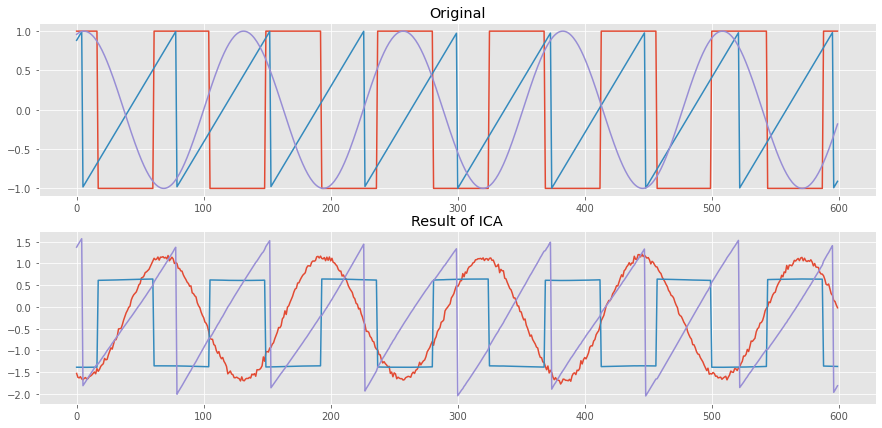

In [234]:
ica = CustomICA().fit(X, iter=int(1e3), tol=1e-5)
S = ica.S
fig, axes = plt.subplots(2, 1, figsize=(15, 7))
ax = axes[0]
ax.set_title("Original")
ax.plot(original_signals)

ax = axes[1]
ax.set_title("Result of ICA")
ax.plot(S)